author: [Lorenzo Perozzi](https://www.linkedin.com/in/lperozzi/)

This notebook provide a quick tour on how download pub tagged as microbrewery in Lausanne, Switzerland, from OpenStreetMap dataset. Then we perform the shortest path from a given point in Lausanne to all the founded microbrewery

In [171]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from IPython.display import IFrame

from descartes import PolygonPatch


import warnings
warnings.filterwarnings('ignore')
ox.__version__

'1.2.2'

OSMNx allow to download a street network from à city name (using Nominatim API), from an address, from a point (with some distance) or form a polygon. Here we use a polygon that include the city center of the Lausanne.

In [172]:
# Read a polygon extracted form QGIS as a geojson
# Get polygon boundary related to the polygon name as a geodataframe
lausanne_city_center = gpd.read_file('data/Lausanne_city_center.geojson') 

# assign a shapely geometry to the polygon
lausanne_city_center_pol = lausanne_city_center.loc[0, 'geometry']

In [173]:
# Fetch OSM street network from the polygon
graph = ox.graph_from_polygon(lausanne_city_center_pol)

/Users/lorenzoperozzi/opt/anaconda3/envs/ox_that_work/lib/python3.11/site-packages/osmnx/plot.py:680: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scalar_mapper = cm.ScalarMappable(normalizer, cm.get_cmap(cmap))


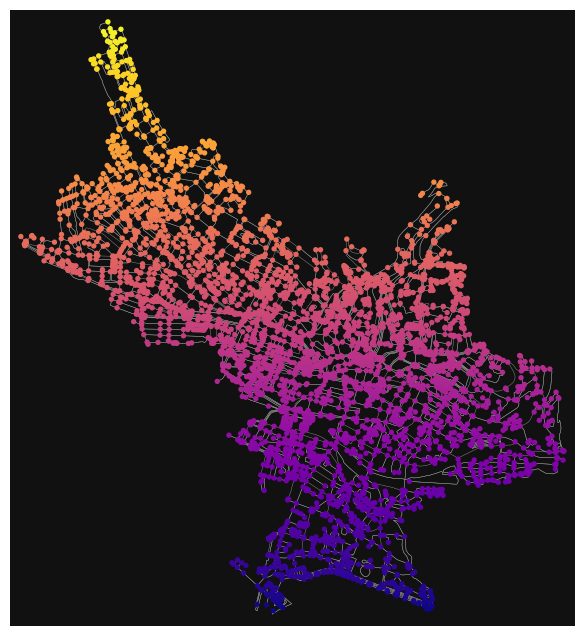

In [187]:
# get node colors by linearly mapping an attribute's values to a colormap
nc = ox.plot.get_node_colors_by_attr(graph, attr="y", cmap="plasma")
fig, ax = ox.plot_graph(graph, node_color=nc, edge_linewidth=0.3)
fig.savefig('figures/Lausanne_graph.png', dpi=300, format='png', bbox_inches='tight')

Then we retrieve the origin point form where we want to model the shortest path to each microbrewery.

In [175]:
# creating the origin from Lausanne Flon
origin = gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(6.631004310693691, 46.52025924145879)
origin.at[0, 'name'] = 'Lausanne Flon'

As well as the microbrewery in Lausanne (based on OSM tags `amenity:pub` and `microbrewery:yes`)

In [176]:
# List key-value pairs for tags
tags = {'amenity': 'pub', 'microbrewery':'yes'}
# Get the data
microbrasseries = ox.geometries_from_polygon(lausanne_city_center_pol, tags)
microbrasseries.reset_index(inplace=True)
microbrasseries.head()

microbrasseries = microbrasseries[['osmid','name', 'addr:housenumber', 'addr:street','geometry']]
microbrasseries = microbrasseries.reset_index(drop=True)
# getting centroids from polygons to avoid polygon geometric objects
microbrasseries['geometry'] = [geom.centroid for geom in microbrasseries['geometry']]
microbrasseries.head(5)

,osmid,name,addr:housenumber,addr:street,geometry
0,365937679,Les Brasseurs,4,Rue Centrale,POINT (6.63258 46.52060)
1,417706015,Le XIIIe siecle,NaN,NaN,POINT (6.63530 46.52341)
2,603714714,Le Central,5,Rue Centrale,POINT (6.63203 46.52076)
3,603722682,King Size pub,16,Rue du Port-Franc,POINT (6.62694 46.52190)
4,826027336,Le Lapin Vert,2,Ruelle du Lapin Vert,POINT (6.63590 46.52359)


Now we model the network using the [shortest path function in OSMnx](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.shortest_path)

/var/folders/fc/40b_clln34l1w72_6wv05b_c0000gn/T/ipykernel_79841/3851100887.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  routes = routes.append([[path]])
/var/folders/fc/40b_clln34l1w72_6wv05b_c0000gn/T/ipykernel_79841/3851100887.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  routes = routes.append([[path]])
/var/folders/fc/40b_clln34l1w72_6wv05b_c0000gn/T/ipykernel_79841/3851100887.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  routes = routes.append([[path]])
/var/folders/fc/40b_clln34l1w72_6wv05b_c0000gn/T/ipykernel_79841/3851100887.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  routes = routes.append([[path

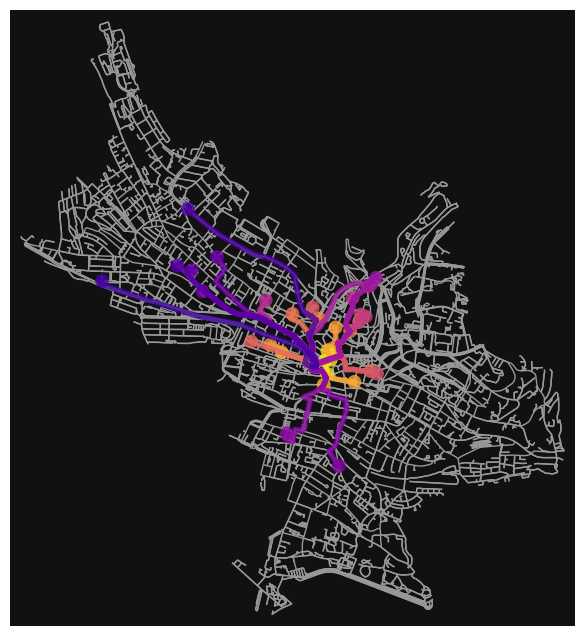

In [188]:
# converting the graph projection in local UTM projection
graph_proj = ox.project_graph(graph)

# get the closest node to the origin point
origin_node = ox.distance.nearest_nodes(G=graph, X=origin.geometry.x, Y=origin.geometry.y)

# get the destinations nodes (microbrewery)
destination_nodes = ox.distance.nearest_nodes(G=graph, X=microbrasseries.geometry.x, Y=microbrasseries.geometry.y)

# Get nodes from the graph
nodes = ox.graph_to_gdfs(graph_proj, edges=False)


# compute the path between origin and each microbrewery node.
routes = gpd.GeoDataFrame()
routes2 = []
route_lengths = []
for o, d in product(origin_node, destination_nodes):
    route = ox.shortest_path(graph, o, d, weight='length')
    routes2.append(route) 
    # Extract the nodes of the route
    # print(route)
    route_nodes = nodes.loc[route]

    # Create a LineString out of the route
    path = LineString(list(route_nodes.geometry.values))
    # Append the result into the GeoDataFrame
    routes = routes.append([[path]])
    route_length = ox.utils_graph.get_route_edge_attributes(graph, route, "length")
    # routes.append(route)
    route_lengths.append(route_length)



# Add a column name geometry
routes.columns = ['geometry']        

# Set geometry
routes = routes.set_geometry('geometry')
# set the same crs as the nodes (UTM)
routes.crs = nodes.crs

route_lengths_total = []
for l in route_lengths:
    total = sum(l)
    route_lengths_total.append(total)
# print(route_lengths_total)
    
# create a dataframe for plotting and exporting 
df = pd.DataFrame({"route":routes2, "node_length":route_lengths, "total_length":route_lengths_total})

# plotting parameters
df_to_plot = df.sort_values(by='total_length')
rc= ox.plot.get_colors(n=len(route_lengths_total), cmap="plasma_r", stop=0.9, return_hex=True)
df_to_plot['color'] = rc
routes['color'] = rc

# plot the result
fig, ax = ox.plot_graph_routes(graph, routes=df.sort_values(by='total_length').route.values.tolist(), route_colors=rc, route_linewidth=6, route_alpha=0.8,node_size=0)
fig.savefig('figures/brew_routes.png', dpi=150, format='png', bbox_inches='tight')

If we want to add the building footprint to the visualization...

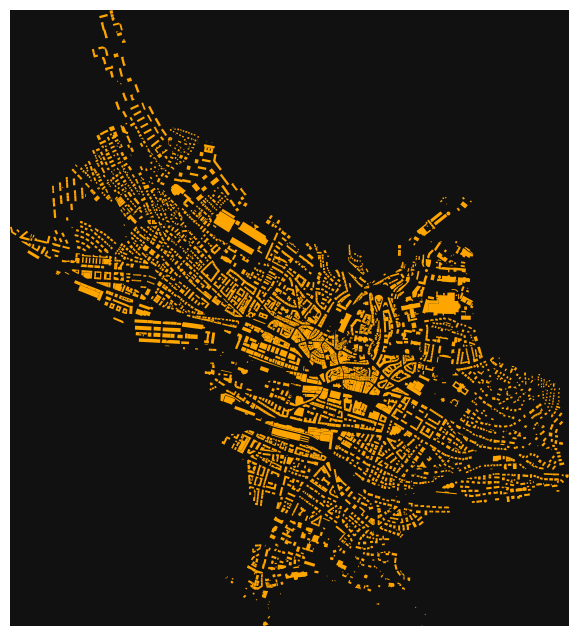

In [189]:
# specify that we're retrieving building footprint geometries
tags = {"building": True}
gdf = ox.geometries_from_polygon(lausanne_city_center_pol, tags)
gdf_proj = ox.project_gdf(gdf)
fig, ax = ox.plot_footprints(gdf_proj, filepath=None, dpi=400, save=False, show=True, close=False)
# Image(fp, height=size, width=size)
fig.savefig('figures/Lausanne_building.png', dpi=150, format='png', bbox_inches='tight')

Plotting network and footprint together

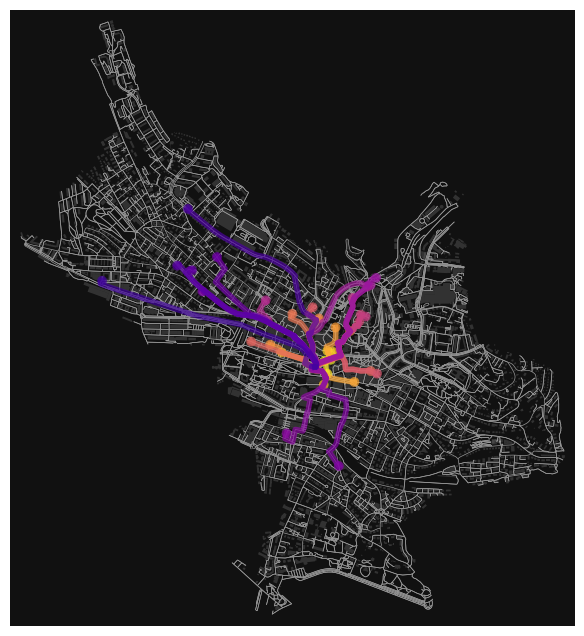

In [192]:

fig, ax = ox.plot_footprints(gdf,alpha=0.4, edge_color='#111111', color='#666666',show=False)
fig, ax = ox.plot_graph(graph, ax=ax, node_size=0, edge_color="#999999", edge_linewidth=0.5, show=False)
fig, ax = ox.plot_graph_routes(graph, ax=ax, routes=df.sort_values(by='total_length').route.values.tolist(), route_colors=rc, route_linewidth=2, orig_dest_size=50, route_alpha=0.7,node_size=0,)
fig.savefig('figures/microbrasseries_shortest_path.png', dpi=150, format='png', bbox_inches='tight')


## Isochrones from origin point 

In [195]:
# add an edge attribute for time in minutes required to traverse each edge

travel_speed = 4.5 # 4.5 km/h walking speed
trip_times = [5, 10, 15, 20, 25]  # in minutes

meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in graph_proj.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [196]:
center_node = ox.distance.nearest_nodes(G=graph, X=origin.geometry.x[0], Y=origin.geometry.y[0])
center_node

8050095188

In [197]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/Users/lorenzoperozzi/opt/anaconda3/envs/ox_that_work/lib/python3.11/site-packages/osmnx/plot.py:45: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_list = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]


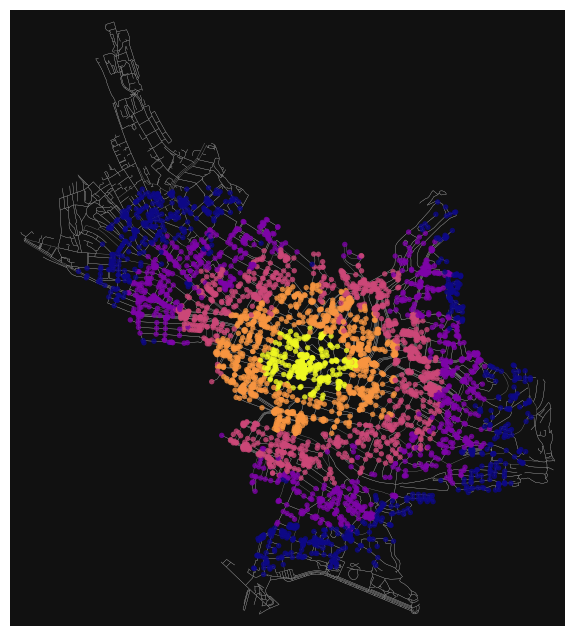

In [198]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(graph_proj, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in graph_proj.nodes()]
ns = [15 if node in node_colors else 0 for node in graph_proj.nodes()]
fig, ax = ox.plot_graph(
    graph_proj,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)
fig.savefig('figures/isonodes_lausanne.png', dpi=150, format='png', bbox_inches='tight')


## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [184]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(graph_proj, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

In [199]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


isochrone_polys = make_iso_polys(graph_proj, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_footprints(gdf_proj,alpha=0.4, color='#666666',show=False)
fig, ax = ox.plot_graph(
    graph_proj, ax=ax, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
fig, ax = ox.plot_graph_routes(graph_proj, ax=ax, show=False, routes=df.sort_values(by='total_length').route.values.tolist(), route_colors='k', route_linewidth=2, orig_dest_size=50, route_alpha=0.7,node_size=0,)

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)

fig.savefig('figures/Lausanne_isochrones.png', dpi=150, format='png', bbox_inches='tight')
fig.show()

/Users/lorenzoperozzi/opt/anaconda3/envs/ox_that_work/lib/python3.11/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/var/folders/fc/40b_clln34l1w72_6wv05b_c0000gn/T/ipykernel_79841/4080846804.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
